In [1]:
import tensorflow as tf
import numpy as np

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from collections.abc import Sequence

class FlowSequence(Sequence):
    def __init__(self, flows = []):
        self.flows = flows
        super().__init__()
        
    def add(self, flow):
        flows = self.flows[:]
        flows.append(flow)
        return FlowSequence(flows)
    
    def __getitem__ (self, i):
        return self.flows[i]
    
    def __len__ (self):
        return len(self.flows)
    
    def apply(self, inp, inverse=False):
        init = NVPFlow(int(inp.shape[-1]), name='input_flow', output=inp)
        
        f = init
        
        if not inverse:
            for flow in self.flows:
                f = flow(f)
        else:
            for flow in self.flows[::-1]:
                f = flow(f, inverse=True)
                
        self.calc_logj()
        
        return f[-1].output
    
    def calc_logj(self):
        logjms = tf.stack([f.logjm for f in self.flows])
        logjm = tf.reduce_sum(logjms, axis=0)
        logj = tf.reduce_sum(logjm, axis=-1)
        self.logj = logj
        return logj

In [3]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt

In [4]:
def Dense(inp, num_n, name='Dense', use_bias=True):
    with tf.variable_scope(name, initializer=tf.random_normal_initializer(mean=0, stddev=0.01)):
        inp_dim = int(inp.shape[-1])
        W = tf.get_variable('W', [inp_dim, num_n])
        pa = tf.matmul(inp, W)
        
        if use_bias:
            bb = 0
            if name=='preelastic':
                bb = -4
            b = tf.get_variable('b', [1, num_n]) + bb
            pa += b
            
    return pa

In [5]:
class NVPFlow:
    def __init__(self, dim=None, name='NVPFlow', output=None):
        self.dim = dim
        self.name = name
        self.output = output
        if output is not None:
            self.mask = np.zeros(dim, np.bool)
        
    def __call__(self, inp_flows=None, inverse=False):
        
        if isinstance(inp_flows, FlowSequence):
            prev_flow_output = inp_flows[-1].output
            dim = int(inp_flows[-1].dim)
        elif isinstance(inp_flows, NVPFlow):
            prev_flow_output = inp_flows.output
            dim = inp_flows.dim
            inp_flows = FlowSequence([inp_flows])
        else:
            raise ValueError('Input flow must be either a flowsequence or a flow')
            
        self.dim = dim
        
        if inp_flows is None:
            
            if hasattr(self, 'mask'):
                mask = self.mask
            else:
                mask = np.zeros(dim, np.bool)
                mask[:dim//2] = True
                self.mask = mask
                
            out_flows = FlowSequence([self])
        else:
            if hasattr(self, 'mask'):
                mask = self.mask
                
            else:
                prev_cover = np.zeros(dim, np.int)
                for flow in inp_flows:
                    prev_cover += flow.mask
                
                sort = np.argsort(prev_cover)[:dim//2]
                mask = np.zeros_like(prev_cover).astype('bool')
                mask[sort] = True
                #print(mask)

                if np.sum(mask) >= dim//2:
                    ix = np.arange(len(mask))[mask]
                    new_ix = np.random.choice(ix, size=dim//2, replace=False)
                    new_mask = np.zeros_like(mask)
                    new_mask[new_ix] = True
                    mask = new_mask

                elif np.sum(mask) < dim//2:
                    ix = np.arange(len(mask))[np.logical_not(mask)]
                    new_ix = np.random.choice(ix, size=dim//2 - np.sum(mask), replace=False)
                    new_mask = np.zeros_like(mask)
                    new_mask[new_ix] = True
                    mask += new_mask
                
                self.mask = mask
            
            out_flows = inp_flows.add(self)
                
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            rescaler = np.ones_like(mask).astype('float32')
            rescaler[np.logical_not(mask)] = 2
            #print(rescaler)
            
            mask = mask[np.newaxis,:]
            
            input_tensor = prev_flow_output*mask
            
            blend_tensor = prev_flow_output*(1 - mask)
            
            gate = Dense(blend_tensor, dim, name='preelastic')
            gate_scaler = 1.5
            gate = tf.log1p(tf.exp(gate))
            
            transition = Dense(blend_tensor, dim, name='transition')
            
            if not inverse:
                transformed = gate*input_tensor + transition
                self.output = transformed * mask + blend_tensor
                
                self.output += inp_flows[-1].output
                self.output /= rescaler
                
            else:
                restored = (input_tensor - transition)/(gate + 1)
                self.output = mask*restored + (1-mask)*blend_tensor
            
            self.logjm =  tf.log1p(gate*mask) - np.log(rescaler)
            
        return out_flows

In [6]:
inp = tf.placeholder(tf.float32, [None, 2])

In [7]:
flow = NVPFlow(2, 'init_flow', inp)

for i in range(0, 12):
    flow = NVPFlow(name=str(i))(flow)

In [8]:
flow[-1].output /= 3

In [9]:
flows = FlowSequence(flow[1:])

In [10]:
logj = flows.calc_logj()

In [11]:
logj

<tf.Tensor 'Sum_1:0' shape=(?,) dtype=float32>

In [12]:
z = flows[-1].output
gain = tf.reduce_sum(-(z**2)/2, axis=-1) + logj
gain = tf.reduce_mean(gain)

In [13]:
def generate_updates(lr, loss):
    opt = tf.train.AdamOptimizer(lr, epsilon=0.01)
    grads = opt.compute_gradients()
    

In [14]:
lr = tf.Variable(0.0001, name='lr', trainable=False)
train_op = tf.train.AdamOptimizer(lr, epsilon=0.01).minimize(-gain)

In [15]:
#plt.scatter(X[:,0], X[:,1])
#plt.show()

In [16]:
sess = tf.InteractiveSession()

In [17]:
tf.global_variables_initializer().run()

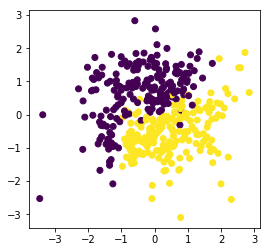

In [32]:
X, y = make_moons(n_samples=400, noise=0.2)
ver = z.eval({inp:X})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [19]:
logj.eval({inp:X}).mean()

-8.1014528

In [30]:
lr.assign(0.0001).eval()

9.9999997e-05

In [21]:
saver = tf.train.Saver()

In [33]:
saver.save(sess, '/tmp/nvpresnet')

'/tmp/nvpresnet'

In [34]:
for _ in range(100000):
    X, y = make_moons(n_samples=200, noise=0.2)
    for i in range(1):
        train_op.run({inp:X})
    
    if _ % 1000 == 0:
        print(gain.eval({inp:X}).mean())

-6.08264


KeyboardInterrupt: 

In [25]:
inverse = flows.apply(inp*3, inverse=True)

In [35]:
restored = inverse.eval({inp:np.random.normal(size=[800,2])})
#restored = inverse.eval({inp:ver})

In [36]:
restored = restored[np.logical_not(np.any(restored**2 > 10, axis=-1))]

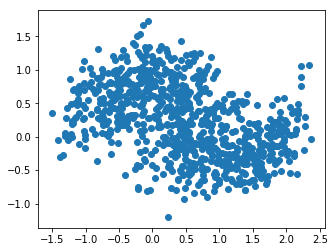

In [37]:
ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(restored[:,0], restored[:,1])
plt.show()